In [1]:
# Library for SPARQL querying
!pip install SPARQLWrapper

In [2]:
# Pandas extension for geographical information (install with conda on windows)
#!pip install geopandas

In [3]:
# Map contexts for geographical plots (install with conda on windows)
#!pip install contextily

  Installing build dependencies: started
  Installing build dependencies: still running...
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'


  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\Benoit\Anaconda3\python.exe' 'C:\Users\Benoit\Anaconda3\lib\site-packages\pip\_vendor\pep517\_in_process.py' get_requires_for_build_wheel 'C:\Users\Benoit\AppData\Local\Temp\tmp8jwhjspj'
       cwd: C:\Users\Benoit\AppData\Local\Temp\pip-install-nx_cjh2d\rasterio
  Complete output (2 lines):
  INFO:root:Building on Windows requires extra options to setup.py to locate needed GDAL files. More information is available in the README.
  ERROR: A GDAL API version must be specified. Provide a path to gdal-config using a GDAL_CONFIG environment variable or use a GDAL_VERSION environment variable.
  ----------------------------------------
ERROR: Command errored out with exit status 1: 'C:\Users\Benoit\Anaconda3\python.exe' 'C:\Users\Benoit\Anaconda3\lib\site-packages\pip\_vendor\pep517\_in_process.py' get_requires_for_build_wheel 'C:\Users\Benoit\AppData\Local\Temp\tmp8jwhjspj' Check the logs for full command output.


## SPARQL From Python (detailled)

In [1]:
import pandas as pd
import json
from SPARQLWrapper import SPARQLWrapper, JSON

In [2]:
sparql = SPARQLWrapper(endpoint="https://query.wikidata.org/sparql")
query = """
SELECT ?building ?buildingLabel ?geo
WHERE 
{
  # Elements whose architect (P84) is Palladio (Q177692)
  ?building wdt:P31 wd:Q2977 .
  # Geographical location (P625)
  ?building wdt:P625 ?geo
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
}
"""
sparql.setQuery(query)
sparql.setReturnFormat(JSON)
query_result = sparql.query()
data_dictionnary = query_result.convert()

In [6]:
# Parsed data as a dictionnary
data_dictionnary

{'head': {'vars': ['building', 'buildingLabel', 'geo']},
 'results': {'bindings': [{'building': {'type': 'uri',
     'value': 'http://www.wikidata.org/entity/Q1306549'},
    'geo': {'datatype': 'http://www.opengis.net/ont/geosparql#wktLiteral',
     'type': 'literal',
     'value': 'Point(8.9315 44.40769444)'},
    'buildingLabel': {'xml:lang': 'en',
     'type': 'literal',
     'value': 'Genoa Cathedral'}},
   {'building': {'type': 'uri',
     'value': 'http://www.wikidata.org/entity/Q1328640'},
    'geo': {'datatype': 'http://www.opengis.net/ont/geosparql#wktLiteral',
     'type': 'literal',
     'value': 'Point(-73.561111111 45.514166666)'},
    'buildingLabel': {'xml:lang': 'en',
     'type': 'literal',
     'value': 'Saint-Jacques Cathedral'}},
   {'building': {'type': 'uri',
     'value': 'http://www.wikidata.org/entity/Q1329512'},
    'geo': {'datatype': 'http://www.opengis.net/ont/geosparql#wktLiteral',
     'type': 'literal',
     'value': 'Point(46.044722222 51.5275)'},
    '

In [10]:
# Data column names
data_dictionnary['head']['vars']

['building', 'buildingLabel', 'geo']

In [14]:
# Data single (first) result
data_dictionnary['results']['bindings'][0]

{'building': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q45033'},
 'geo': {'datatype': 'http://www.opengis.net/ont/geosparql#wktLiteral',
  'type': 'literal',
  'value': 'Point(16.607361111 49.190972222)'},
 'buildingLabel': {'xml:lang': 'en',
  'type': 'literal',
  'value': 'cathedral of St. Peter and Paul'}}

## All in a function

The function will directly query the SPARQL endpoint and convert the data in a DataFrame.

If some columns are GPS coordinates, they will be converted to a `GeoSerie` using the `geopandas` package.

In [3]:
from shapely.geometry import Point
import geopandas
from geopandas import GeoDataFrame
from shapely import wkt

def get_sparql_dataframe(service, query, has_geo_data=False):
    """
    Helper function to convert SPARQL results into a Pandas data frame.
    Adapted from http://lawlesst.github.io/notebook/sparql-dataframe.html
    """
    sparql = SPARQLWrapper(service)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    result = sparql.query()

    data_dictionnary = result.convert()
    cols = data_dictionnary['head']['vars']

    out = []
    for row in data_dictionnary['results']['bindings']:
        item = []
        for c in cols:
            v = row.get(c, {}).get('value')
            t = row.get(c, {}).get('datatype')
            if has_geo_data and (t == 'http://www.opengis.net/ont/geosparql#wktLiteral'):
                v = wkt.loads(v)
            item.append(v)
        out.append(item)

    if has_geo_data:
        return GeoDataFrame(out, columns=cols, crs="EPSG:4326")  # setting the default coordinate reference system
    else:
        return pd.DataFrame(out, columns=cols)

## Example accessing data

In [15]:
service = "https://query.wikidata.org/sparql"
query = """
SELECT ?building ?buildingLabel ?geo ?classLabel (year(?startDate) as ?startYear) ?styleLabel ?countryLabel
WHERE 
{
  # Is of class
  ?building wdt:P31 ?class .
  # Class is subclass of cathedral
  ?class wdt:P279* wd:Q2977 .
  # Has geographical coordinates
  ?building wdt:P625 ?geo .
  # Is in country
  ?building wdt:P17 ?country .
  # Country is in Europe
  ?country wdt:P30 wd:Q46 .
  ?building wdt:P149 ?style .
  OPTIONAL{?building wdt:P571 ?startDate }
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en" }
}
"""
df = get_sparql_dataframe(service, query, has_geo_data=True)
# Specifies which column is the default "geometry" column for geopandas
df = df.set_geometry('geo')
# Convert coordinate system to the one used by map providers
df.crs = {'init': 'epsg:4326'}
df = df.to_crs(epsg=3857)
# Properly converting startYear column to numerical
df.startYear = pd.to_numeric(df.startYear)

In [16]:
df[:10]

,building,buildingLabel,geo,classLabel,startYear,styleLabel,countryLabel
0,http://www.wikidata.org/entity/Q1329745,Grasse Cathedral,POINT (770856.552 5412634.344),cathedral,NaN,Romanesque architecture,France
1,http://www.wikidata.org/entity/Q1333235,basilica of Sant'Eufemia,POINT (1490036.876 5728658.330),cathedral,NaN,paleochristian architecture,Italy
2,http://www.wikidata.org/entity/Q1336613,Transfiguration Cathedral,POINT (5485603.426 7079958.403),cathedral,NaN,Russian Revival architecture,Russia
3,http://www.wikidata.org/entity/Q1378149,St. Salvator's Cathedral,POINT (358606.166 6657726.533),cathedral,NaN,Gothic architecture,Belgium
4,http://www.wikidata.org/entity/Q1385934,Cathedral of Santa Ana,POINT (-1715959.028 3261692.524),cathedral,NaN,Neoclassical architecture,Spain
5,http://www.wikidata.org/entity/Q1456266,Fridolinsmünster Bad Säckingen,POINT (884927.613 6032776.549),cathedral,NaN,baroque architecture,Germany
6,http://www.wikidata.org/entity/Q1476251,Saint Sophia Cathedral,POINT (3714112.966 4187877.601),cathedral,NaN,Gothic architecture,Republic of Cyprus
7,http://www.wikidata.org/entity/Q1499188,Catania Cathedral,POINT (1679594.711 4509382.187),cathedral,NaN,Norman architecture,Italy
8,http://www.wikidata.org/entity/Q1499188,Catania Cathedral,POINT (1679594.711 4509382.187),cathedral,NaN,baroque architecture,Italy
9,http://www.wikidata.org/entity/Q1538555,Goslar Cathedral,POINT (1160817.386 6782659.704),cathedral,NaN,Romanesque architecture,Germany


## Basic look at the data obtained

In [18]:
df.countryLabel.value_counts()

Italy                             395
France                            198
United Kingdom                    153
Spain                             140
Russia                             85
Germany                            70
Ukraine                            41
Ireland                            40
Poland                             40
Finland                            36
Portugal                           31
Croatia                            26
Romania                            22
Hungary                            19
Czech Republic                     19
Sweden                             18
Norway                             15
Austria                            15
Greece                             14
Belgium                            13
Belarus                            13
Slovakia                           12
Switzerland                        12
Denmark                            11
Latvia                             10
Netherlands                         9
Lithuania   

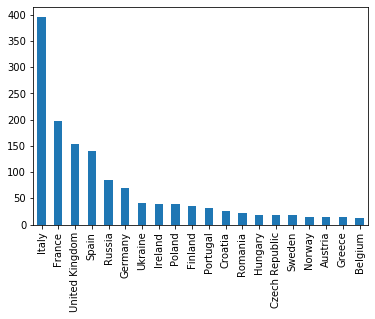

In [20]:
df.countryLabel.value_counts()[:20].plot(kind='bar')

In [105]:
df.classLabel.value_counts()

cathedral                          835
Catholic cathedral                 318
co-cathedral                       122
anglican or episcopal cathedral    107
orthodox cathedral                  89
Lutheran cathedral                  78
duomo                               16
Imperial Cathedral                   5
pro-cathedral                        4
Name: classLabel, dtype: int64

In [193]:
df.styleLabel.value_counts()[:15]

Romanesque architecture            288
Gothic architecture                287
baroque architecture               164
Gothic Revival architecture        134
Neoclassical architecture           88
Romanesque Revival architecture     41
Byzantine Revival architecture      38
Baroque                             37
Renaissance architecture            36
Russian Revival architecture        33
Norman architecture                 28
Brick Gothic                        26
Gothic art                          23
Renaissance                         19
Armenian architecture               18
Name: styleLabel, dtype: int64

## Map Visualisation

For explanations about using a base map see https://geopandas.readthedocs.io/en/latest/gallery/plotting_basemap_background.html

Depending on the zoom level of the maps, they might take significant time to appear the first time they are loaded.

In [17]:
import contextily as ctx

### Global European View

Index(['Romanesque architecture', 'Gothic architecture',
       'baroque architecture', 'Gothic Revival architecture',
       'Neoclassical architecture', 'Romanesque Revival architecture',
       'Byzantine Revival architecture', 'Baroque', 'Renaissance architecture',
       'Russian Revival architecture'],
      dtype='object')


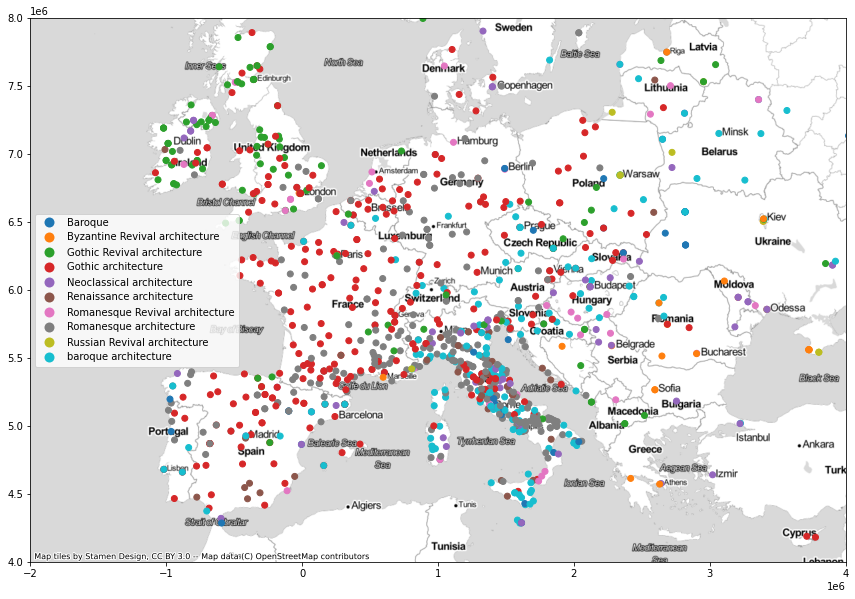

In [18]:
# Only select the most common architectural styles
most_common_styles = df.styleLabel.value_counts()[:10].index
print(most_common_styles)
# Filtered the data according to those
filtered_df = df[df.styleLabel.isin(most_common_styles)]
ax = filtered_df.plot(
    column='styleLabel', # Dot color according to this column
    figsize=(15, 10),
    legend=True)
# Change the map limits
ax.set_xlim(xmin=-0.2e7, xmax=0.4e7)
ax.set_ylim(ymin=0.4e7, ymax=0.8e7)
# Add a map background
ctx.add_basemap(ax, zoom=5, source=ctx.providers.Stamen.TonerLite)

### Italian View

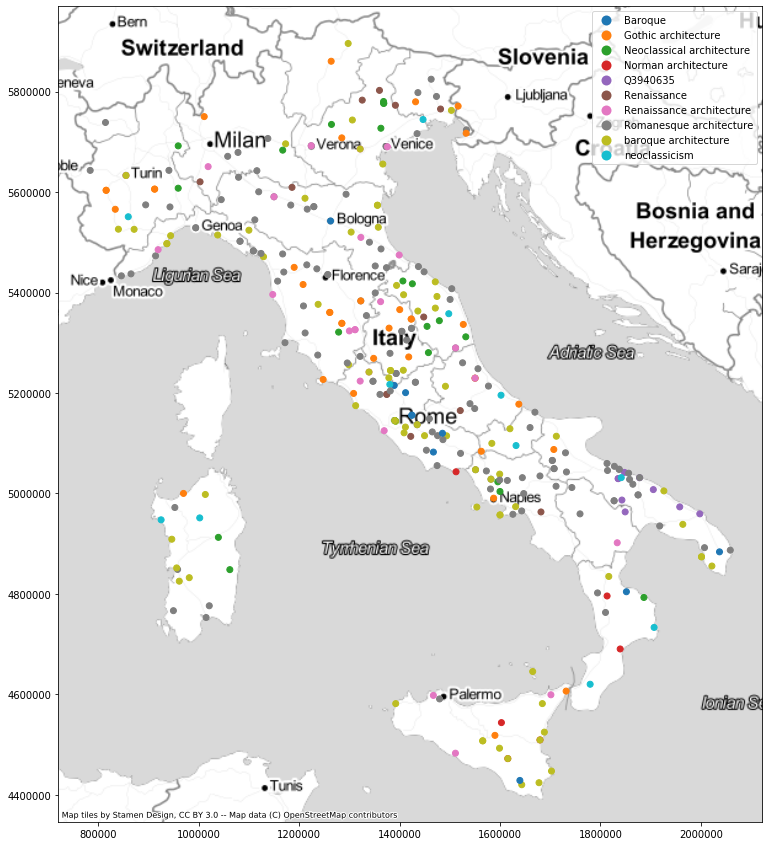

In [196]:
italian_cathedrals = df[df.countryLabel == 'Italy']
ax = italian_cathedrals[italian_cathedrals.styleLabel.isin(italian_cathedrals.styleLabel.value_counts()[:10].index)].plot(
    column='styleLabel',
    figsize=(15, 15),
    legend=True,
    cmap='tab10')
# Map background
ctx.add_basemap(ax, zoom=6, source=ctx.providers.Stamen.TonerLite)

### French View

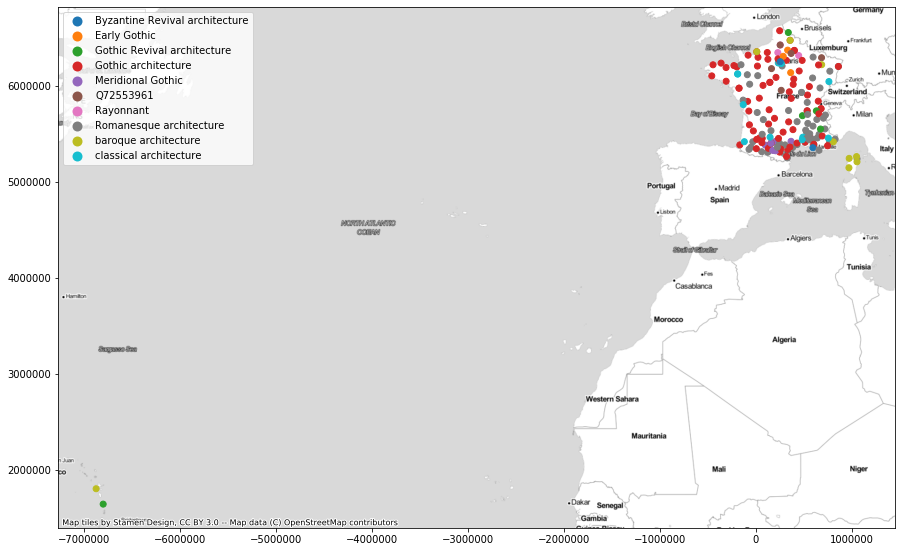

In [24]:
french_cathedrals = df[df.countryLabel == 'France']
most_common_styles = french_cathedrals.styleLabel.value_counts()[:10].index
ax = french_cathedrals[french_cathedrals.styleLabel.isin(most_common_styles)].plot(
    column='styleLabel',
    figsize=(15, 15),
    legend=True,
    cmap='tab10')

ctx.add_basemap(ax, zoom=5, source=ctx.providers.Stamen.TonerLite)

In [25]:
french_cathedrals.styleLabel.value_counts()[:17]

Gothic architecture                74
Romanesque architecture            58
classical architecture             13
baroque architecture                9
Gothic Revival architecture         7
Meridional Gothic                   7
Q72553961                           6
Rayonnant                           4
Early Gothic                        4
Byzantine Revival architecture      3
Neoclassical architecture           2
French Gothic architecture          2
pre-Romanesque art                  1
Russian Revival architecture        1
Romanesque Revival architecture     1
Brick Gothic                        1
Byzantine architecture              1
Name: styleLabel, dtype: int64

### French Gothic with time

In [26]:
gothic_styles = ['Meridional Gothic', 'Gothic architecture', 'Early Gothic', 'French Gothic architecture', 'Rayonnant']
french_gothic_cathedrals = french_cathedrals[french_cathedrals.styleLabel.isin(gothic_styles)]
french_gothic_cathedrals = french_gothic_cathedrals[pd.notna(french_gothic_cathedrals.startYear) & (french_gothic_cathedrals.startYear>1050)]

In [27]:
french_gothic_cathedrals.sort_values('startYear')

,building,buildingLabel,geo,classLabel,startYear,styleLabel,countryLabel
110,http://www.wikidata.org/entity/Q1788518,Church of St. Trophime,POINT (515192.788 5415541.188),cathedral,1101.0,Gothic architecture,France
971,http://www.wikidata.org/entity/Q184407,Basilica of Saint-Denis,POINT (262683.076 6263933.586),Catholic cathedral,1101.0,Gothic architecture,France
1032,http://www.wikidata.org/entity/Q585947,Laon Cathedral,POINT (403533.154 6371159.416),Catholic cathedral,1101.0,Gothic architecture,France
994,http://www.wikidata.org/entity/Q489014,Sens Cathedral,POINT (365539.144 6139839.882),Catholic cathedral,1135.0,Early Gothic,France
1222,http://www.wikidata.org/entity/Q2942394,Pontoise Cathedral,POINT (233461.710 6283443.972),Catholic cathedral,1145.0,Gothic architecture,France
426,http://www.wikidata.org/entity/Q932828,Noyon Cathedral,POINT (334025.264 6374215.022),cathedral,1145.0,Early Gothic,France
1298,http://www.wikidata.org/entity/Q1736217,Senlis Cathedral,POINT (287884.572 6310048.765),cathedral,1153.0,Early Gothic,France
936,http://www.wikidata.org/entity/Q2981,Notre-Dame de Paris,POINT (261578.539 6249955.279),Catholic cathedral,1163.0,Early Gothic,France
935,http://www.wikidata.org/entity/Q2981,Notre-Dame de Paris,POINT (261578.539 6249955.279),Catholic cathedral,1163.0,Rayonnant,France
934,http://www.wikidata.org/entity/Q2981,Notre-Dame de Paris,POINT (261578.539 6249955.279),Catholic cathedral,1163.0,French Gothic architecture,France


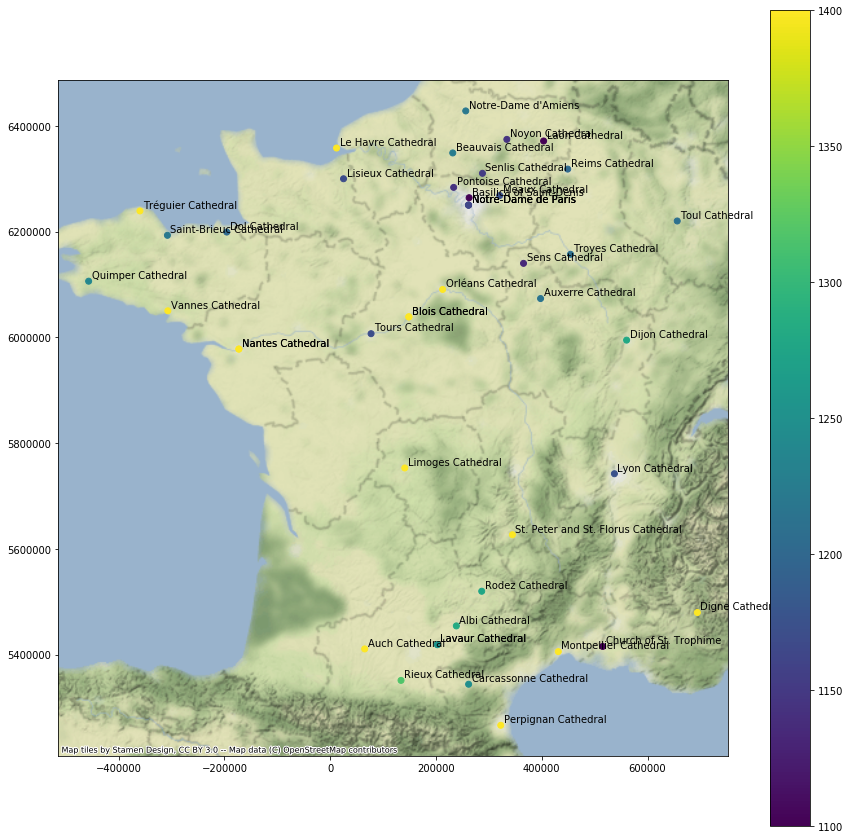

In [28]:
ax = french_gothic_cathedrals.plot(column='startYear',
    figsize=(15, 15), vmin=1100, vmax=1400,
    legend=True)
ctx.add_basemap(ax, zoom=6, source=ctx.providers.Stamen.TerrainBackground)

# Print text (annotate function) for each point
for i, row in french_gothic_cathedrals.iterrows():
    ax.annotate(row.buildingLabel, xy=(row.geo.x, row.geo.y), xytext=(3, 3), textcoords="offset points")

### European Gothic with time

In [206]:
gothic_cathedrals = df[df.styleLabel.isin(gothic_styles)]
gothic_cathedrals = gothic_cathedrals[pd.notna(gothic_cathedrals.startYear)]
gothic_cathedrals = gothic_cathedrals[gothic_cathedrals.startYear > 1050]

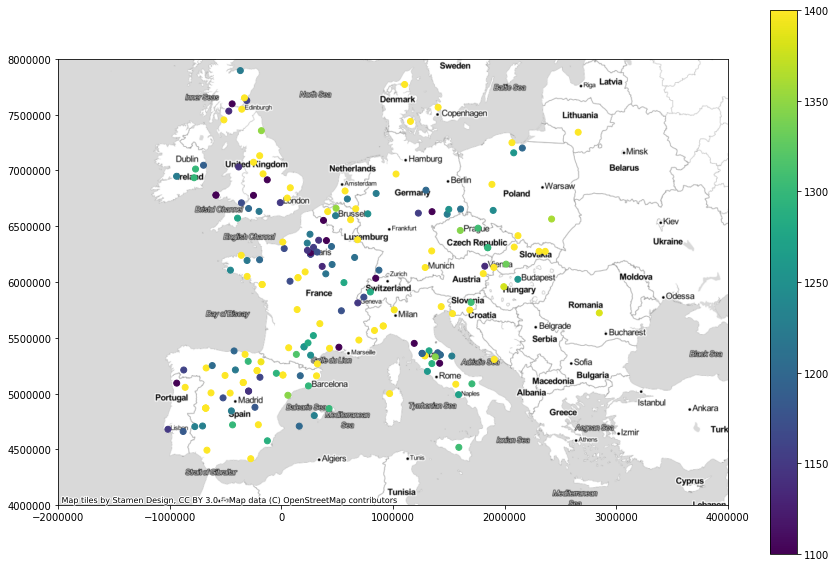

In [213]:
ax = gothic_cathedrals.plot(column='startYear',
    figsize=(15, 10), vmin=1100, vmax=1400,
    legend=True)
ax.set_xlim(xmin=-0.2e7, xmax=0.4e7)
ax.set_ylim(ymin=0.4e7, ymax=0.8e7)
ctx.add_basemap(ax, zoom=5, source=ctx.providers.Stamen.TonerLite)

## Take-away

We wanted to see if we could visualize the gothic spread through time and space. However without additional information the `inception` date we have of cathedral is imprecise as it can refer to earlier building rather than the beginning of gothic modifications.

Nevertheless, the commonly accepted birth area (Paris and north of Paris) seems visible.